
# Denoising Autoencoder

In this notebook, you will implement a denoising autoencoder using convolutional layers that will be capable of denoising the MNIST digits.

In [2]:
import torch
import numpy as np
from torchvision import datasets
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from visualize_util import visualize_img_batch

In [4]:
# Use this if you are using any Cuda enabled system
if torch.cuda.is_available():
    device = 'cuda'
# elif torch.backends.mps.is_available():
#     device = 'mps' 
else:
    device = 'cpu'
print(device)

cpu


## Load MNIST Dataset 

In [6]:
# TODO:convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the training and test datasets
mnist_train = datasets.MNIST('./data', train=True,
                                   download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False,
                                  download=True, transform=transform)

#TODO
n_epochs = 15
batch_size = 64

# prepare data loaders
loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2)
loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, num_workers=2)

### Visualize the Data

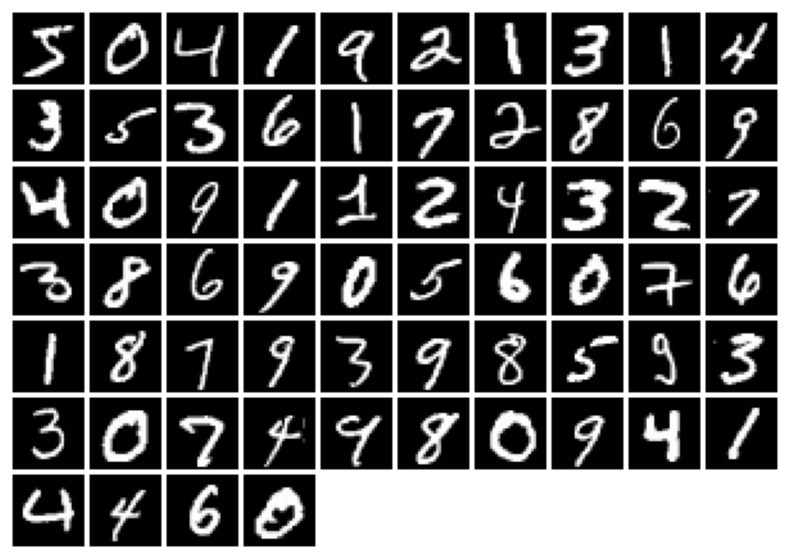

In [7]:
imgs = next(iter(loader_train))[0].numpy().squeeze()
visualize_img_batch(imgs)

In [16]:
# nn.Conv2d?
nn.ConvTranspose2d?

Init signature:
nn.ConvTranspose2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[int, Tuple[int, int]] = 0,
    output_padding: Union[int, Tuple[int, int]] = 0,
    groups: int = 1,
    bias: bool = True,
    dilation: Union[int, Tuple[int, int]] = 1,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 2D transposed convolution operator over an input image
composed of several input planes.

This module can be seen as the gradient of Conv2d with respect to its input.
It is also known as a fractionally-strided convolution or
a deconvolution (although it is not an actual deconvolution operation as it does
not compute a true inverse of convolution). For more information, see the visualizations
`here`_ and the `Deconvolutional Networks`_ paper.

This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

On certain ROCm devices, when

In [265]:
class DenoiseAE(nn.Module):
    def __init__(self):
        super(DenoiseAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1, padding=1), 
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), 
            # layer 2
            nn.Conv2d(8, 16, 3, 1, padding=1),  
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),  
            # layer 3
            nn.Conv2d(16, 32, 3, 1, padding=1),  
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)  
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, output_padding=1),  
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2, output_padding=0), 
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2), 
            nn.BatchNorm2d(1),
            nn.LeakyReLU(),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [266]:
from torchsummary import summary
denoise_autoencoder = DenoiseAE().to(device)
summary(denoise_autoencoder,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
         LeakyReLU-3            [-1, 8, 28, 28]               0
         MaxPool2d-4            [-1, 8, 14, 14]               0
            Conv2d-5           [-1, 16, 14, 14]           1,168
       BatchNorm2d-6           [-1, 16, 14, 14]              32
         LeakyReLU-7           [-1, 16, 14, 14]               0
         MaxPool2d-8             [-1, 16, 7, 7]               0
            Conv2d-9             [-1, 32, 7, 7]           4,640
      BatchNorm2d-10             [-1, 32, 7, 7]              64
        LeakyReLU-11             [-1, 32, 7, 7]               0
        MaxPool2d-12             [-1, 32, 3, 3]               0
  ConvTranspose2d-13             [-1, 16, 7, 7]           2,064
      BatchNorm2d-14             [-1, 1

---
## Training


In [267]:
criterion = nn.MSELoss() # TODO: specify loss function
optimizer = optim.Adam(denoise_autoencoder.parameters(), lr=1e-3) # TODO: specify optimizer

noise_factor=0.5

for epoch in range(n_epochs):
    train_loss = 0.0
    #TODO
    for images, _ in loader_train:
        optimizer.zero_grad()
        images = images.to(device)
        # add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = torch.clip(noisy_imgs, 0., 1.)
        # Use the noisy images during the forward pass
        output = denoise_autoencoder(noisy_imgs)
        # calculate the loss between the original (not-noisy) and the predicted
        loss = criterion(output, images)
        # Backward pass
        loss.backward()
        optimizer.step()         
        # update running training loss
        train_loss += loss.item()
    
    # print avg training statistics 
    train_loss = train_loss/len(loader_train)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 0.224754
Epoch: 1 	Training Loss: 0.216592
Epoch: 2 	Training Loss: 0.214804
Epoch: 3 	Training Loss: 0.213299
Epoch: 4 	Training Loss: 0.211758
Epoch: 5 	Training Loss: 0.210140
Epoch: 6 	Training Loss: 0.208531
Epoch: 7 	Training Loss: 0.206898
Epoch: 8 	Training Loss: 0.205266
Epoch: 9 	Training Loss: 0.203607
Epoch: 10 	Training Loss: 0.201970
Epoch: 11 	Training Loss: 0.200302
Epoch: 12 	Training Loss: 0.198600
Epoch: 13 	Training Loss: 0.196890
Epoch: 14 	Training Loss: 0.195170


## Results


noisy images:


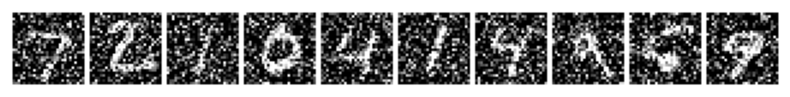

denoised images:


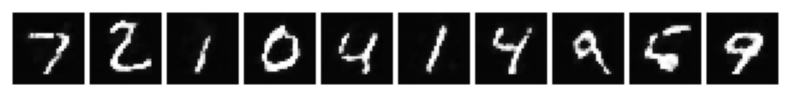

In [268]:
images = next(iter(loader_test))[0][0:10,:,:,:] # assume batch size >10

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = torch.clip(noisy_imgs, 0., 1.)

# show noisy images
print('noisy images:')
visualize_img_batch(noisy_imgs.numpy().squeeze())
plt.show()

# get sample outputs
output = denoise_autoencoder(noisy_imgs.to(device))

# show denoised images
print('denoised images:')
visualize_img_batch(output.detach().cpu().numpy().squeeze())
plt.show()